In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# importing necessary library for implementing the project 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
import keras
from keras.layers import Dense, LSTM, Dropout, GRU, Flatten, Activation, BatchNormalization
import numpy as np

### Dataset

In [4]:
# read dataset using pandas library
df = pd.read_csv("/content/gdrive/MyDrive/Implementation/revenue/chatbot/dataset.csv")
df  

,date,pandemic/economic slow down,Avg salary,unemployment(%),total employees,Attrition % in the company,Steel Price,Oil Price,Oil Consumption,GDP,Inflation,revenue
0,31-01-2009,no,35454,4.93,1780,2.57,90.3,43.44,46371.566,-1.7,2.2,1035.7
1,28-02-2009,no,35464,4.92,1783,2.73,96.8,43.32,44278.000,-1.7,2.2,1040.7
2,31-03-2009,no,35474,4.88,1786,1.96,183.0,46.54,46000.000,-1.7,2.2,1045.1
3,30-04-2009,no,35454,4.87,1770,3.27,84.8,50.18,44854.000,-1.7,2.2,1048.5
4,31-05-2009,no,35464,4.85,1774,2.49,103.4,57.30,44930.000,-1.7,2.2,1078.5
...,...,...,...,...,...,...,...,...,...,...,...,...
162,31-08-2022,no,52538,4.06,2207,2.93,96.3,111.93,54440.000,3.8,6.9,1709.1
163,30-09-2022,no,52540,3.99,2212,3.40,167.1,100.45,53011.000,3.8,7.5,1719.9
164,31-10-2022,no,52546,3.30,2230,2.90,163.8,93.33,52178.000,3.8,6.5,1520.7
165,30-11-2022,no,52560,3.20,2235,2.75,160.9,91.42,55118.000,3.8,5.9,1596.0


In [5]:
# label_encoder object knows how to understand word labels.
df = df.replace('yes ','yes')
df = df[df["pandemic/economic slow down"].isnull()==False]

# Encode labels in column 'pandemic/economic slow down'.
label_encoder = preprocessing.LabelEncoder()
df["pandemic/economic slow down"] = label_encoder.fit_transform(df["pandemic/economic slow down"])
df["pandemic/economic slow down"].unique()

array([0, 1])

In [6]:
# feature name is represented below
df.columns

Index(['date', 'pandemic/economic slow down', 'Avg salary', 'unemployment(%)',
       'total employees', 'Attrition % in the company', 'Steel Price',
       'Oil Price', 'Oil Consumption', 'GDP', 'Inflation', 'revenue'],
      dtype='object')

In [7]:
# replace the index value into Dateset for getting year,month,day,hour,no of week
df = df.set_index('date')
df.index = pd.to_datetime(df.index, format='%d-%m-%Y')

In [8]:
# Adding Time and Date into dataset
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.weekofyear
    
    return df

df_data = create_features(df)

<ipython-input-8-250544979a9b>:13: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = df.index.weekofyear


In [9]:
# information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 167 entries, 2009-01-31 to 2022-12-31
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   pandemic/economic slow down  167 non-null    int64  
 1   Avg salary                   167 non-null    int64  
 2   unemployment(%)              167 non-null    float64
 3   total employees              167 non-null    int64  
 4   Attrition % in the company   167 non-null    float64
 5   Steel Price                  167 non-null    float64
 6   Oil Price                    167 non-null    float64
 7   Oil Consumption              167 non-null    float64
 8   GDP                          167 non-null    float64
 9   Inflation                    167 non-null    float64
 10  revenue                      167 non-null    float64
dtypes: float64(8), int64(3)
memory usage: 15.7 KB


In [10]:
df.describe()

,pandemic/economic slow down,Avg salary,unemployment(%),total employees,Attrition % in the company,Steel Price,Oil Price,Oil Consumption,GDP,Inflation,revenue
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,0.257485,44082.281437,4.158084,1722.646707,2.715629,89.128204,61.007952,50624.980707,1.732934,2.444910,1926.810778
std,0.438564,5230.236557,0.487034,246.290823,0.470869,35.687457,26.745679,2414.050170,1.871937,1.273486,813.914555
min,0.000000,35454.000000,3.200000,1300.000000,1.900000,29.850000,20.331000,44278.000000,-2.800000,0.700000,952.200000
25%,0.000000,39850.000000,3.745000,1497.000000,2.315000,60.695000,40.474000,49010.707000,1.400000,1.900000,1412.250000
50%,0.000000,44448.000000,4.160000,1745.000000,2.720000,85.720000,51.329000,51170.473000,2.000000,2.200000,1659.200000
75%,1.000000,48624.000000,4.575000,1918.500000,3.115000,107.015000,80.934000,52763.271500,2.300000,2.800000,2358.100000
max,1.000000,52897.000000,4.990000,2242.000000,3.530000,183.000000,125.625000,55118.000000,4.100000,7.500000,4109.800000


### Data Visualization

In [ ]:
df.corr()

,pandemic/economic slow down,Avg salary,unemployment(%),total employees,Attrition % in the company,Steel Price,Oil Price,Oil Consumption,GDP,Inflation,revenue
pandemic/economic slow down,1.000000,0.085663,0.170979,0.009492,-0.010561,-0.398777,-0.307158,0.056010,-0.066159,-0.312055,-0.211118
Avg salary,0.085663,1.000000,-0.572477,0.591326,0.017608,0.256301,0.349310,0.858511,0.237392,0.543332,0.421756
unemployment(%),0.170979,-0.572477,1.000000,-0.266014,-0.019544,-0.582956,-0.655538,-0.718243,-0.149162,-0.208993,-0.883786
total employees,0.009492,0.591326,-0.266014,1.000000,0.071303,0.549812,0.527123,0.482746,-0.020747,0.469040,0.303101
Attrition % in the company,-0.010561,0.017608,-0.019544,0.071303,1.000000,0.019850,0.087610,-0.019311,-0.017612,0.098490,-0.001785
Steel Price,-0.398777,0.256301,-0.582956,0.549812,0.019850,1.000000,0.775421,0.328666,0.048987,0.365143,0.664553
Oil Price,-0.307158,0.349310,-0.655538,0.527123,0.087610,0.775421,1.000000,0.451433,0.043979,0.372722,0.726196
Oil Consumption,0.056010,0.858511,-0.718243,0.482746,-0.019311,0.328666,0.451433,1.000000,0.139849,0.322920,0.650666
GDP,-0.066159,0.237392,-0.149162,-0.020747,-0.017612,0.048987,0.043979,0.139849,1.000000,0.316844,0.099676
Inflation,-0.312055,0.543332,-0.208993,0.469040,0.098490,0.365143,0.372722,0.322920,0.316844,1.000000,0.022021


<Axes: title={'center': 'Correlation Matrix'}>

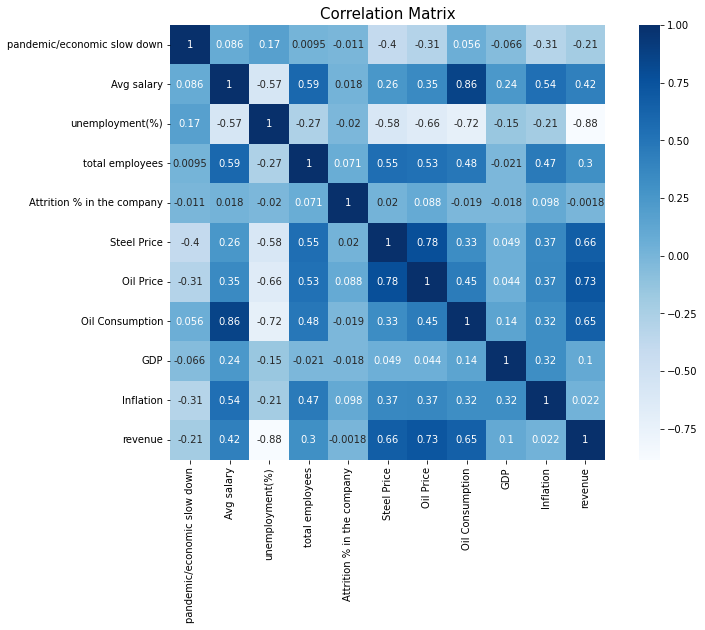

In [ ]:
# Heat map or Correlation Matrix
corrmat = df.corr()
plt.figure(figsize=(12,8))
plt.title('Correlation Matrix', fontsize=15)
sns.heatmap(corrmat,annot=True,cmap="Blues",square=True)


Above Heat map represents the correlation between the each features in the dataset. Here we can see that Avg Salary is more correlated with revenue compared to other features.

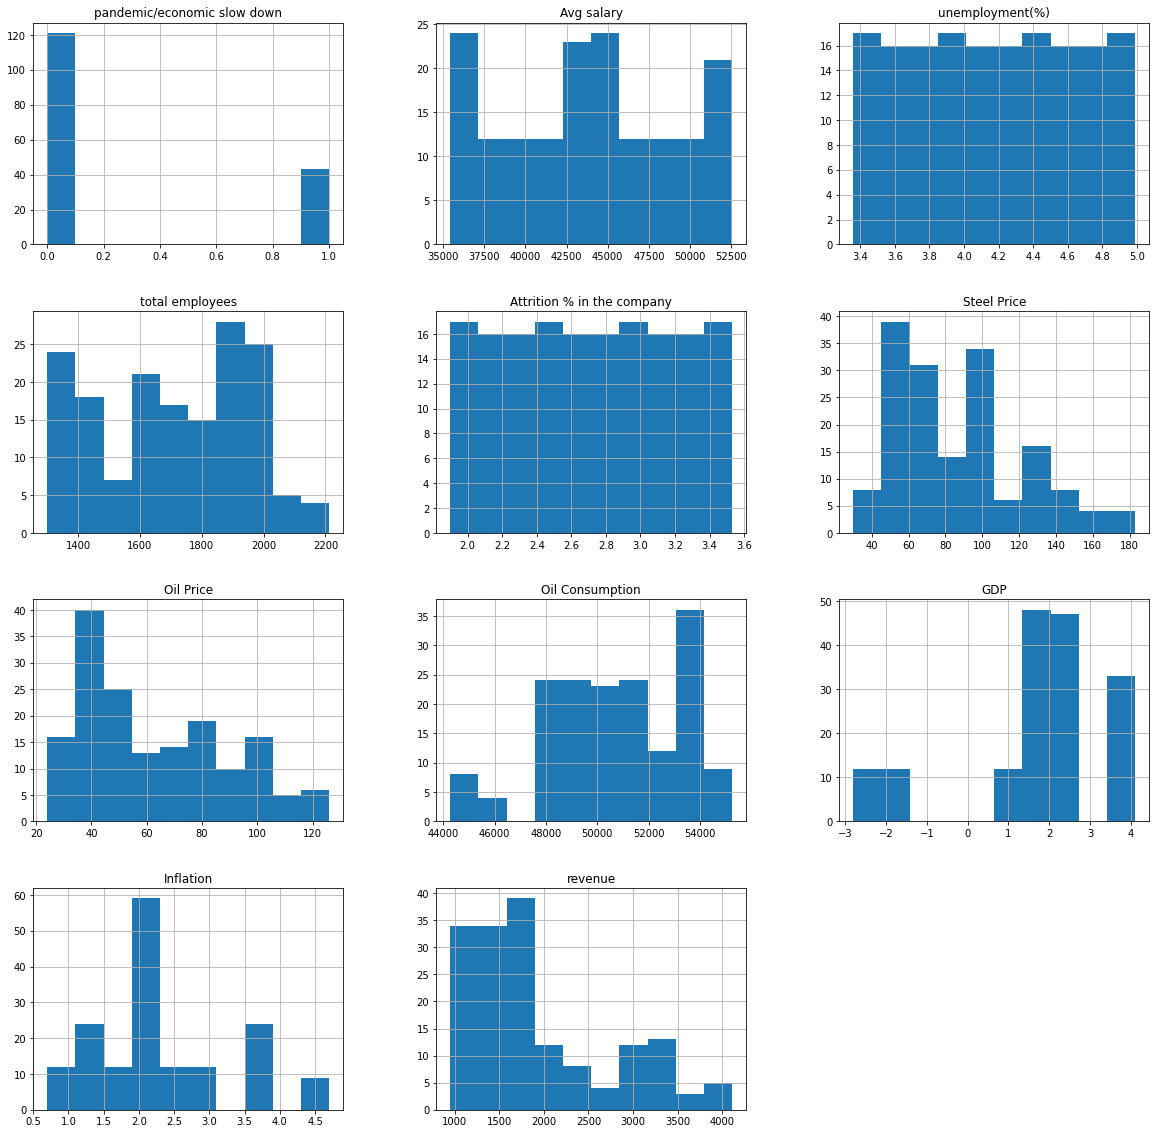

In [ ]:
# Histogram plot
df.hist(figsize=(20,20))
plt.show()

Above graph shows the frequency distributions of each feature and that are measured on an interval scale of the feature.

<AxesSubplot:title={'center':'Missing value in the dataset'}, ylabel='date'>

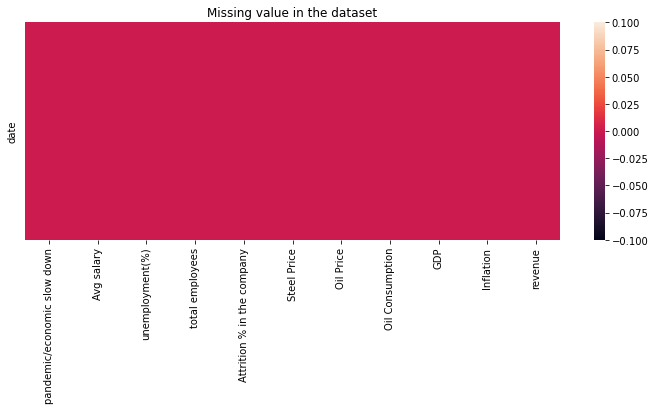

In [ ]:
# Check missing value 
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,4))
plt.title('Missing value in the dataset');
sns.heatmap(data=df.isnull(), yticklabels=False)

Above graph shows the missing value presents in dataset and it will be denoted by black colour. Since there is no null in the dataset, there is no black spot.

Text(0.5, 1.0, 'Revenue Boxplots by Each Month')

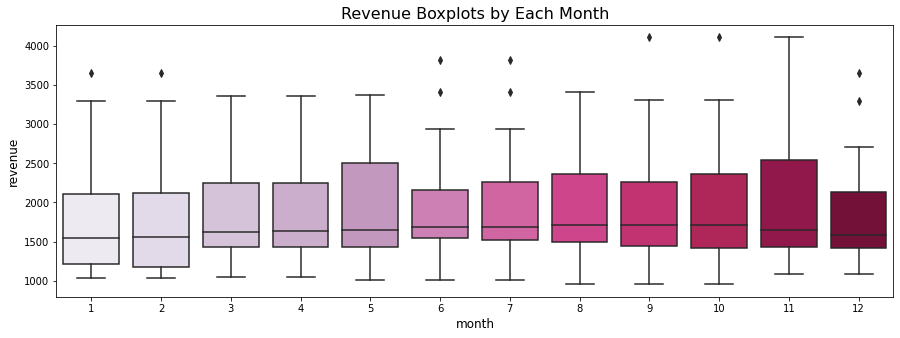

In [ ]:
# Boxplot Graph
plt.figure(figsize=(15,5))
sns.boxplot(x=df.index.month, y='revenue', data=df, palette="PuRd")
plt.ylabel('revenue', fontsize=12)
plt.xlabel('month', fontsize=12)
plt.title("Revenue Boxplots by Each Month", fontsize=16)

Above graph shows the minimum, first quartile, median, third quartile and maximum for each month. Maximum and minimum revenue is in november and october month respectively.

Text(0.5, 1.0, 'Revenue Boxplots by Each Year')

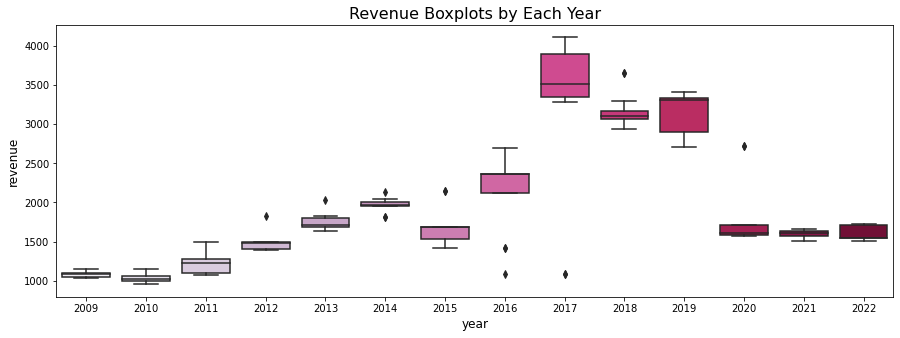

In [ ]:
# Boxplot Graph
plt.figure(figsize=(15,5))
sns.boxplot(x=df.index.year, y='revenue', data=df, palette="PuRd")
plt.ylabel('revenue', fontsize=12)
plt.xlabel('year', fontsize=12)
plt.title("Revenue Boxplots by Each Year", fontsize=16)

Above graph shows, the revenue is linearly increasing from 2009 to 2014, then it starts decrease due to economic slow down, in 2017 the revenue in more compared to other years.

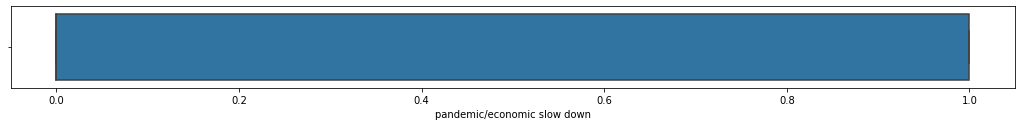

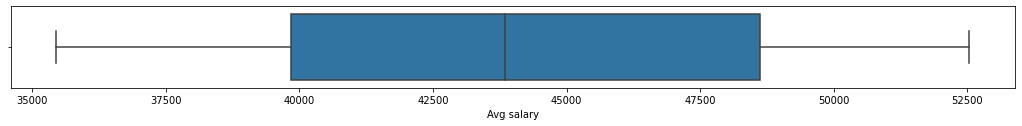

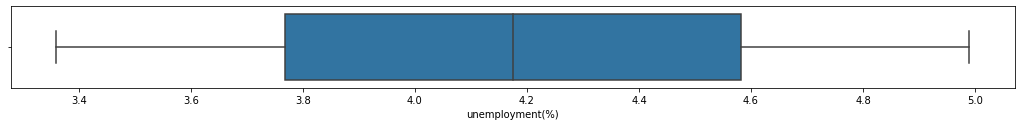

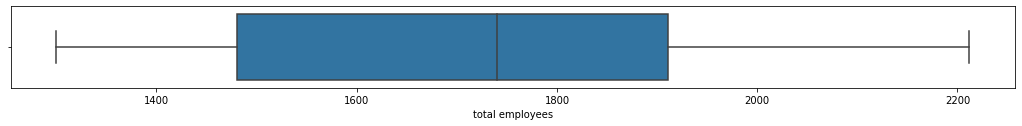

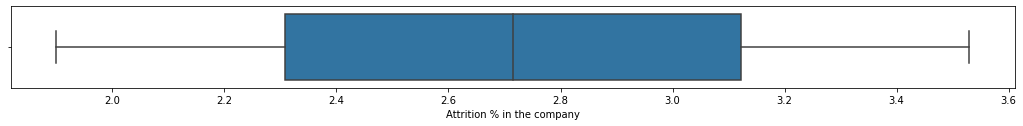

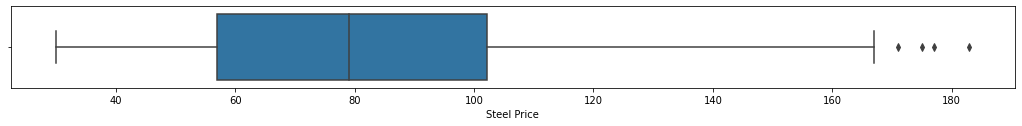

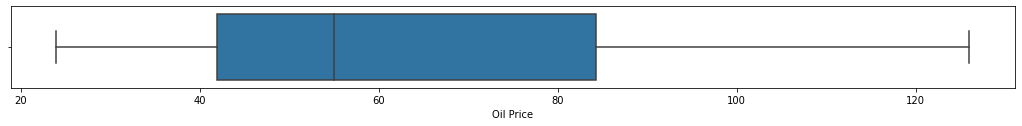

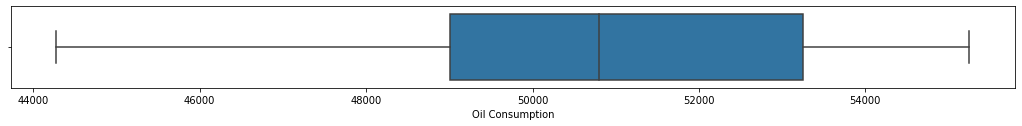

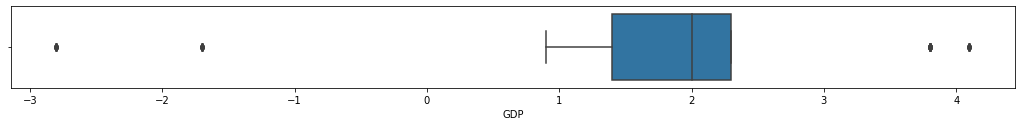

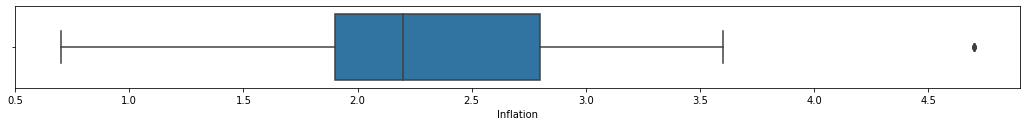

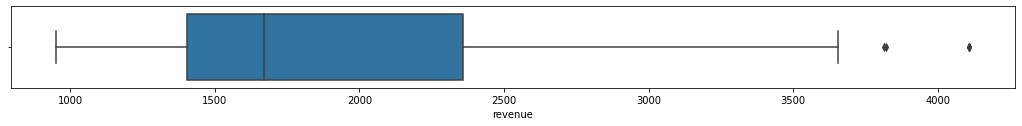

In [ ]:
# Boxplots of all the feature data
for column in df:   
    fig,ax = plt.subplots(figsize=(18,1.5))
    sns.boxplot(data=df, x=column) 

Above box plot shows how the data is distributed in each column and also show the outliers, it is observed that, outliers are in steel price, oil price and revenue.

Text(0, 0.5, 'revenue')

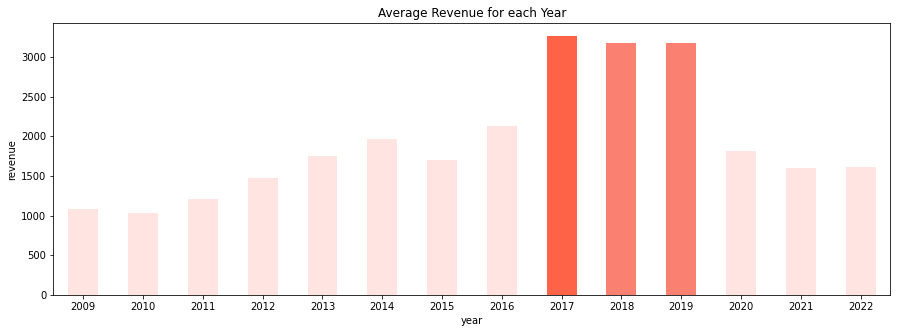

In [ ]:
# Time Series Graph.
plt.figure(figsize=(15,5))
color = list(np.full(12, 'mistyrose'))
color[8], color[9], color[10] = 'tomato', 'salmon', 'salmon'

df_data.groupby('year').mean().revenue.plot(kind='bar', title='Average Revenue for each Year', color=color, rot=0)
plt.ylabel('revenue')


Above shows the average revenue obtained for each year, from 2017 to 2019 the revenue of the company is more compared to other year.

### Data Pre-processing

In [11]:
# inserting revenue column as last column in the dataset
first_column = df_data.pop('revenue')
df_data.insert(17, 'revenue', first_column)
df_data.columns

Index(['pandemic/economic slow down', 'Avg salary', 'unemployment(%)',
       'total employees', 'Attrition % in the company', 'Steel Price',
       'Oil Price', 'Oil Consumption', 'GDP', 'Inflation', 'dayofweek',
       'month', 'quarter', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
       'revenue'],
      dtype='object')

In [152]:
# Separarting feature and predict output
X = df_data.iloc[:,:-1]
y = df_data.iloc[:,-1]

In [153]:
# Robust Scaler which removes the median and scales 
# the data according to the quantile range
fea_stscaler = RobustScaler()
lab_stscaler = RobustScaler()
fea_stscaler.fit(X)
lab_stscaler.fit(y.values.reshape(-1, 1))
X = fea_stscaler.transform(X)
y = lab_stscaler.transform(y.values.reshape(-1,1))

In [154]:
values = pd.concat([pd.DataFrame(X), pd.DataFrame(y)],axis = 1)
values.columns = df_data.columns
values.index = df_data.index

In [155]:
# splitting the dataset into train and test
training_sample = int(len(df_data) *0.9)
train = values.iloc[:training_sample, :]
test = values.iloc[training_sample:, :]
# split into input and outputs
X, y = values.iloc[:, :-1], values.iloc[:, -1]
X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]

In [58]:
# Analyzing How much data is preset in training and validation
data = {'total data':[len(X_train),len(X_test),len(y_train),len(y_test)]}
pd.DataFrame.from_dict(data, orient='index',columns=["X_train","X_test","y_train","y_test"])

,X_train,X_test,y_train,y_test
total data,150,17,150,17


### Linear Regression

In [77]:
# training using Linear Regression Method
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [80]:
# calculating performance metrics
from sklearn.metrics import *
from math import sqrt

pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

# Mean Squared Error
lr_train_mse = mean_squared_error(y_train, pred_train)
lr_test_mse = mean_squared_error(y_test, pred_test)

# # R2 Score
# lr_train_r2 = r2_score(y_train, pred_train)
# lr_test_r2 = r2_score(y_test, pred_test)

# Root Mean Squared Error
lr_train_rmse = sqrt(mean_squared_error(y_train, pred_train))
lr_test_rmse = sqrt(mean_squared_error(y_test, pred_test))

# Mean Absolute Error
lr_train_mae = mean_absolute_error(y_train, pred_train)
lr_test_mae = mean_absolute_error(y_test, pred_test)

data = {
    # 'R2 Score':[lr_train_r2, lr_test_r2],
    'MSE':[lr_train_mse, lr_test_mse],
    'MAE':[lr_train_mae, lr_test_mae],
    'RMSE':[lr_train_rmse, lr_test_rmse],
    }
pd.DataFrame.from_dict(data, orient='index', columns=["train","test"])


,train,test
MSE,0.034523,0.201066
MAE,0.148113,0.281498
RMSE,0.185804,0.448404


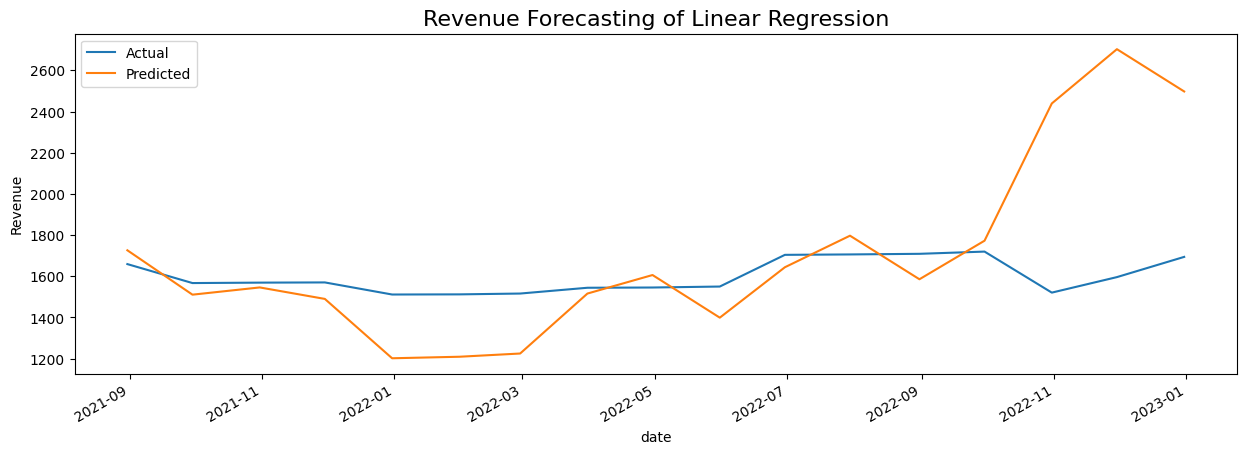

In [79]:
# Actual and Predicted values 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,5)

df_pred = pd.DataFrame(lab_stscaler.inverse_transform(y_test.values.reshape(-1,1)), columns=['Actual'])
df_pred['Predicted'] = lab_stscaler.inverse_transform(pred_test.reshape(-1,1))
df_pred.index = test.index

df_pred.plot(legend = True)
plt.ylabel('Revenue')
plt.title("Revenue Forecasting of Linear Regression", fontsize=16)
plt.legend()
plt.show()

From the above graph, it is observed that the predicted data is not matching with actual data, there is slight variance with actual and predicted, but pattern of predicted is almost same as actual.

### LSTM Model(Long Short Term Memory)

In [64]:
# building lstm model
def lstm_model(X_train):
    model = Sequential()
    model.add(LSTM(units =128, activation='relu', return_sequences=True, input_shape = (X_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units =128, activation='relu', return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units =128, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1)) # Prediction of the next value
    model.compile(optimizer='adam', loss='mae')
    model.summary()
    return model

In [68]:
# model checkpoint will store weight whenever loss value is decreasing
checkpointer = keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/Implementation/revenue/lstm_weight.h5', verbose=1, save_best_only=True, monitor='val_loss')

# training lstm model
model = lstm_model(X_train)
H = model.fit(X, y, validation_data = (X_test,y_test), batch_size = 8, epochs = 200, callbacks=[checkpointer])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 17, 128)           66560     
                                                                 
 dropout_3 (Dropout)         (None, 17, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 17, 128)           131584    
                                                                 
 dropout_4 (Dropout)         (None, 17, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                

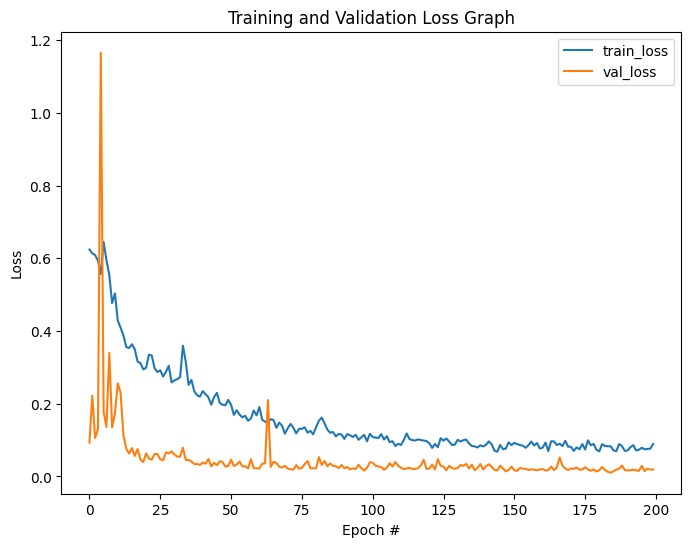

In [69]:
# Plotting graph for Training and Validation loss vs each epochs
plt.figure(figsize=(8,6))
plt.plot(np.arange(0, 200), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 200), H.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss Graph")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [70]:
# calculating performance metrics
from sklearn.metrics import *
from math import sqrt

model_lstm = keras.models.load_model('/content/gdrive/MyDrive/Implementation/revenue/lstm_weight.h5')

pred_train = model_lstm.predict(X_train)
pred_test = model_lstm.predict(X_test)

# Mean Squared Error
lstm_train_mse = mean_squared_error(y_train, pred_train)
lstm_test_mse = mean_squared_error(y_test, pred_test)

# R2 Score
lstm_train_r2 = r2_score(y_train, pred_train)
lstm_test_r2 = r2_score(y_test, pred_test)

# Root Mean Squared Error
lstm_train_rmse = sqrt(mean_squared_error(y_train, pred_train))
lstm_test_rmse = sqrt(mean_squared_error(y_test, pred_test))

# Mean Absolute Error
lstm_train_mae = mean_absolute_error(y_train, pred_train)
lstm_test_mae = mean_absolute_error(y_test, pred_test)

data = {
    'R2 Score':[lstm_train_r2, lstm_test_r2],
    'MSE':[lstm_train_mse, lstm_test_mse],
    'MAE':[lstm_train_mae, lstm_test_mae],
    'RMSE':[lstm_train_rmse, lstm_test_rmse],
    }

pd.DataFrame.from_dict(data, orient='index', columns=["train","test"])

1/1 [==============================] - 0s 34ms/step


<ipython-input-70-cfdabc122934>:29: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true))


,train,test
R2 Score,0.993751,0.969427
MSE,0.005022,0.000203
MAE,0.051842,0.010274
RMSE,0.070867,0.014255


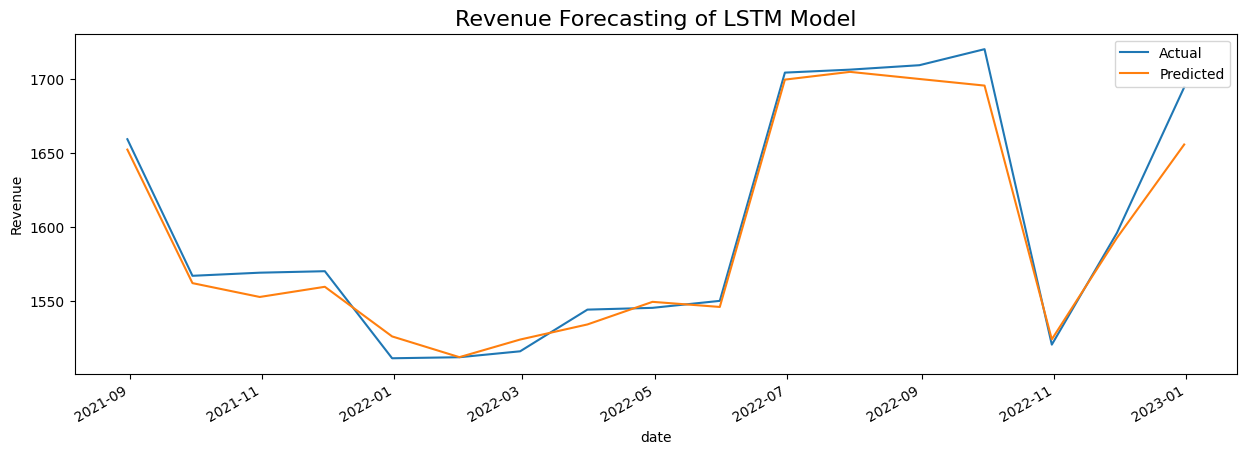

In [71]:
# Actual and Predicted values 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,5)

df_pred = pd.DataFrame(lab_stscaler.inverse_transform(y_test.values.reshape(-1,1)), columns=['Actual'])
df_pred['Predicted'] = lab_stscaler.inverse_transform(pred_test.reshape(-1,1))
df_pred.index = test.index

df_pred.plot(legend = True)
plt.ylabel('Revenue')
plt.title("Revenue Forecasting of LSTM Model", fontsize=16)
plt.legend()
plt.show()

Above graph shows, the pattern of the actual data is matched to the predicted data, so will get the graph almost equal to the actual data.

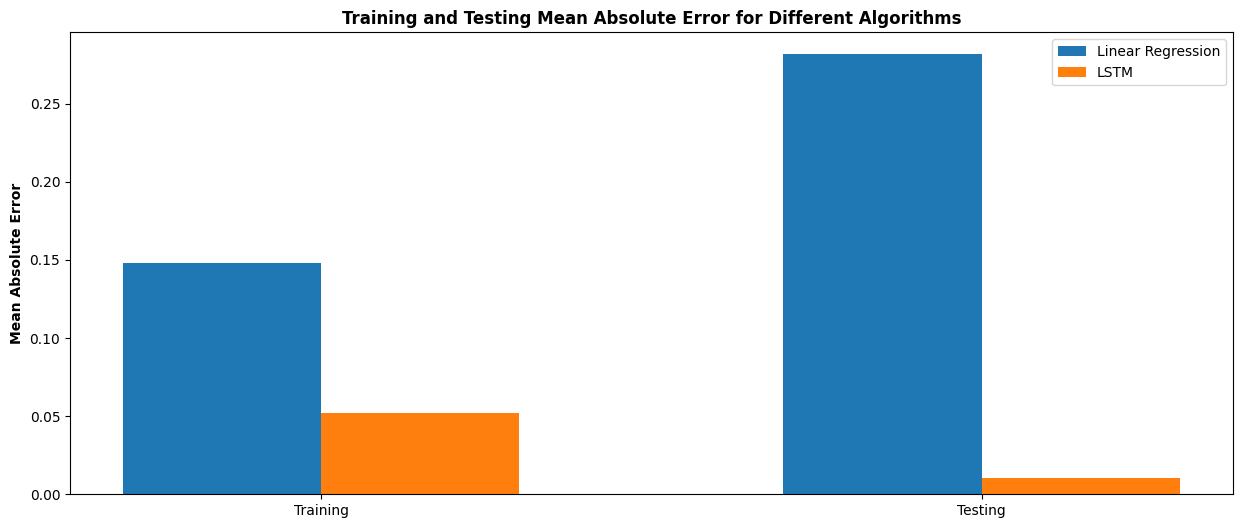

In [72]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6))

lr_mae = [lr_train_mae, lr_test_mae]
lstm_mae = [lstm_train_mae, lstm_test_mae]

bar_width = 0.3
bars = plt.bar(np.arange(len(lr_mae)), lr_mae, width=bar_width, label='Linear Regression')
plt.bar(np.arange(len(lstm_mae)) + bar_width, lstm_mae, width=bar_width, label='LSTM')

plt.xticks([r + bar_width/2 for r in range(len(lstm_mae))], ['Training', 'Testing'])

plt.title('Training and Testing Mean Absolute Error for Different Algorithms', fontweight ='bold')
plt.ylabel('Mean Absolute Error', fontweight ='bold')
plt.legend()
plt.show()

Similarly, if we compare Mean Absolute Error, the LSTM model error rate almost half of the Linear Regression Algorithm. So it states that LSTM is best for timeseries forecasting compared to Linear Regression.

### Revenue Forecasting

In [81]:
input = [0,	35454,	4.93,	1780,	2.57,	90.3,	43.44,	46371.566,	-1.7,	2.2,	5,	1,	1,	2009,	31,	31,	5]
input = fea_stscaler.transform([input])
model_lstm = keras.models.load_model('/content/gdrive/MyDrive/Implementation/revenue/lstm_weight.h5')
pred = model_lstm.predict(input)
lab_stscaler.inverse_transform(pred)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 2s 2s/step


array([[1065.4333]], dtype=float32)

In [149]:
!pip install pyngrok
!pip install flask-ngrok
!pip install flask-cors==3.0.7
!ngrok authtoken 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=536df629633253ad0a9c4502f433e0a977e45e64b94f956b7d8892f323d98d6e
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
# libraries
import random
import numpy as np
import pickle
import json
import re
import datetime as dt
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok
import nltk
from keras.models import load_model
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


# chat initialization
model = load_model("gdrive/MyDrive/Implementation/revenue/chatbot/chatbot_model.h5")
intents = json.loads(open("gdrive/MyDrive/Implementation/revenue/chatbot/intents.json").read())
words = pickle.load(open("gdrive/MyDrive/Implementation/revenue/chatbot/words.pkl", "rb"))
classes = pickle.load(open("gdrive/MyDrive/Implementation/revenue/chatbot/classes.pkl", "rb"))

app = Flask(__name__)
run_with_ngrok(app) 

@app.route('/revenue', methods=['GET','POST'])
def login():
    result = input(request.json['uri'])
    return result

def input(uri):
    print(uri)
    msg = uri
    # try:
    if 'revenue' in uri.lower():
        pred_months = list(map(int, re.findall('\d+', uri)))[0]
        forecasted_revenue = revenue_forecasting(pred_months)
        x = pd.DataFrame(forecasted_revenue.index)[0].dt.strftime('%b-%Y').values.tolist()
        y = forecasted_revenue['Forecasted revenue'].values.tolist()
        json_str = json.dumps({'status': True, 'data': x, 'data2': y, 'type': 1})
        return (json_str)
    # except:
    elif msg.startswith('my name is'):
        name = msg[11:]
        ints = predict_class(msg, model)
        res1 = getResponse(ints, intents)
        res =res1.replace("{n}",name)
        print(res)
        return ({'status': True, 'data': res, 'type': 0})

    elif msg.startswith('hi my name is'):
        name = msg[14:]
        ints = predict_class(msg, model)
        res1 = getResponse(ints, intents)
        res =res1.replace("{n}",name)
        print(res)
        # return res
        return ({'status': True, 'data': res, 'type': 0})
    else:
        ints = predict_class(msg, model)
        res = getResponse(ints, intents)
        print(res)
        return ({'status': True, 'data': res, 'type': 0})

# chat functionalities
def clean_up_sentence(sentence):
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words


# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence
def bow(sentence, words, show_details=True):
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)
    # bag of words - matrix of N words, vocabulary matrix
    bag = [0] * len(words)
    for s in sentence_words:
        for i, w in enumerate(words):
            if w == s:
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print("found in bag: %s" % w)
    return np.array(bag)


def predict_class(sentence, model):
    # filter out predictions below a threshold
    p = bow(sentence, words, show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

def getResponse(ints, intents_json):
    tag = ints[0]["intent"]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents:
        if i["tag"] == tag:
            result = random.choice(i["responses"])
            break
    return result

def revenue_forecasting(pred_months):
    X_forecast_pt = X.head(pred_months)
    model = keras.models.load_model('/content/gdrive/MyDrive/Implementation/revenue/lstm_weight.h5')
    forecasted_pt = model.predict(X_forecast_pt)
    # define index for next months
    last_date=X.iloc[-1].name
    # last_date=dt.datetime.now()
    modified_date = last_date + dt.timedelta(days=28)
    new_date = pd.date_range(modified_date, periods=pred_months,freq='M')

    # assign prediction to newly defined index
    forecasted_pt = pd.DataFrame(forecasted_pt, columns=['Forecasted revenue'], index=new_date)
    
    return forecasted_pt

if __name__ == "__main__":
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://2abd-34-86-72-219.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
Hi
1/1 [==============================] - 0s 66ms/step


INFO:werkzeug:127.0.0.1 - - [25/Mar/2023 10:18:57] "POST /revenue HTTP/1.1" 200 -


hi there, how can i help you
Show Revenue for next 2 months 


/usr/local/lib/python3.9/dist-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '31-01-2009' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/usr/local/lib/python3.9/dist-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '28-02-2009' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/usr/local/lib/python3.9/dist-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '31-03-2009' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/usr/local/lib/python3.9/dist-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '30-04-2009' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/usr/local/lib/python3.9/dist-packages/panda

1/1 [==============================] - 0s 395ms/step


INFO:werkzeug:127.0.0.1 - - [25/Mar/2023 10:19:08] "POST /revenue HTTP/1.1" 200 -


Show revenue for next 3 months


/usr/local/lib/python3.9/dist-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '31-01-2009' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/usr/local/lib/python3.9/dist-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '28-02-2009' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/usr/local/lib/python3.9/dist-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '31-03-2009' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/usr/local/lib/python3.9/dist-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '30-04-2009' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/usr/local/lib/python3.9/dist-packages/panda

1/1 [==============================] - 0s 389ms/step


INFO:werkzeug:127.0.0.1 - - [25/Mar/2023 10:19:38] "POST /revenue HTTP/1.1" 200 -


Show revenue for next 4 months 


/usr/local/lib/python3.9/dist-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '31-01-2009' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/usr/local/lib/python3.9/dist-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '28-02-2009' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/usr/local/lib/python3.9/dist-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '31-03-2009' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/usr/local/lib/python3.9/dist-packages/pandas/io/parsers/base_parser.py:1070: UserWarning: Parsing '30-04-2009' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(
/usr/local/lib/python3.9/dist-packages/panda

1/1 [==============================] - 1s 587ms/step


INFO:werkzeug:127.0.0.1 - - [25/Mar/2023 10:20:06] "POST /revenue HTTP/1.1" 200 -
